In [1]:
#Cold dipole solution with grad(phi) = 0 at the coil  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import Dipole_Tools as dt
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix, linalg as sla
from scipy.interpolate import RectBivariateSpline, interp1d
from numba import jit, njit, prange
from matplotlib import rc
rc('text',usetex=True)

In [3]:
#Set-up of the grid according to the traps geometry, the boundary conditions and natural constants
#Apex config
R_coil = 15.3/2  #coil radius APEX trap
dR_coil = 2.1 
R_wall = 3*R_coil #20 
H = 2*R_coil #13 

#Matt`s config
#R_coil = 3.8
#dR_coil = 1.3
#R_wall = 14
#H = 24

c = 2.99e10 #Speed of light
e = 1.602e-20*c #elementary charge
q = -e #electron charge
me = 9.109e-28 #electron mass

#B0 = 1 #Magnetic field B(r=0, z=0) due to the inner coil in Tesla
I = 54e3*0.1*c #Current in the inner coil of APEX Trap
T0 = 1e7*1.602e-19 #Plasma temperature (1 eV in erg)
omega = 1e6 #Rotation frequency in rad/s
N0 = 3.92e9 #Total Number of particles
C = I/c
delta = 0.01   #Step width for the change of the potentiall from one iteration to the next
ddelta = 0.1*delta #Change of step width if error decreases
delta_min = ddelta #Minimum Step width
guess = 1 # 0 if no initial guess exists, else 1
itr = 100 # Number of iterations, shoulb be at least 1/delta

res_r = 3000 # Radial number of grid points
res_z = 1000 # Longitudinal number of grid points

filename_load = 'LTE'
filename_save = 'LTE'

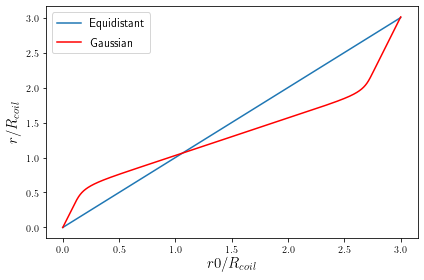

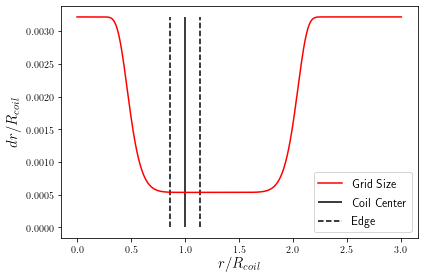

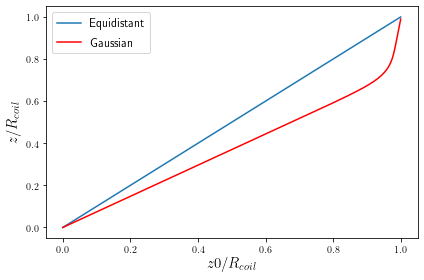

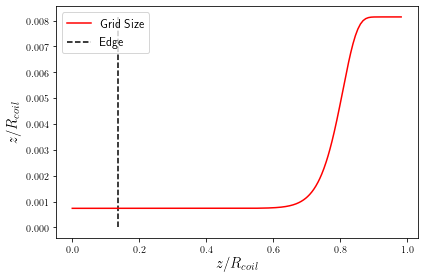

In [4]:
def spacing_r(r, dr, R_wall, R_coil, res_r):
    
    sigma_dr = (R_wall-R_coil)/2.5#Width of the gaussian
    #APEX
    dr0 = 2.68*R_wall/res_r #Diastance of the first grid points. I chose this value so that sum(dr) = R_wall
    #Matt
    #dr0 = 2.85*R_wall/res_r #Diastance of the first grid points. I chose this value so that sum(dr) = R_wall
    dr_min = dr0*0.2 #Minimal Distance of two grid points
    R_exp = 1.25*R_coil #Maxima of the super-gaussian = minima in grid spacing
    exp_r = 10
    
    if len(dr) == 0:
        dr = 2*[dr0+dr_min]
        r = [R_wall, R_wall-dr0]
    dr_i = 2*dr[-1] - dr[-2] #of the next grid point to calculate the corresponding spacing
    dr.append(dr0*(1-np.exp(-(r[-1]-dr[-1]-R_exp)**exp_r/(sigma_dr**exp_r)))+dr_min) #and I need the spacing
    r.append(r[-1]-dr[-1])
    
    return r, dr

def spacing_z(z, dz, R_coil, H, res_z):
    
    sigma_dz = 0.4*H
    dz0 = 3.7*H/res_z
    dz_min = 0.1*dz0
    exp_z = 20

    if len(dz) == 0:
        dz = 2*[dz0+dz_min]
        z = [H/2, H/2-dz0]
    dz_i = 2*dz[-1] - dz[-2]
    dz.append(dz0*(1-np.exp(-(z[-1]-dz[-1])**exp_z/(2*sigma_dz**exp_z)))+dz_min)
    z.append(z[-1]-dz[-1])
        
    return z, dz

r, z, dr, dz, r0, z0 = dt.grid(R_coil, R_wall, H, res_r, res_z, spacing_r, spacing_z, 0)
show = dt.check_grid(r, z, r0, z0, R_coil, dR_coil, dr, dz, res_r, res_z)

In [5]:
f_lte = np.loadtxt(filename_load+'_'+str(0.1)+'distribution.txt')
F0 = dt.N_tot(f_lte, r, z, dr, dz, res_r, res_z)
N0 = F0/(4*np.pi*e)
print('N = %1.2e' %(N0))
mask_lte = np.zeros((res_r, res_z))
mask_lte[f_lte>1e-5] = 1

N = 1.07e+10


In [6]:
z_ue = abs(z-dR_coil/2) #height of the upper edge of the coil 
i_ue = np.argmin(z_ue) #index of the upper edge of the coil
i_le = 0
r_ie = abs(r-(R_coil-dR_coil/2)) #radius of the inner edge of the coil 
i_ie = np.argmin(r_ie) #index of the inner edge of the coil 
r_oe = abs(r-(R_coil+dR_coil/2)) #radius of the outer edge of the coil 
i_oe = np.argmin(r_oe) #index of the outer edge of the coil
i_coil = np.argmin(abs(r-(R_coil))) #index of the outer edge of the coil
i_bottom = np.argmin(abs(r-(r[i_oe]+r[-1])/2)) #Index of the radius in between coil and wall 
                                               #(approximatly the bottom of the potential well)
i_mid = np.argmin(abs(z))

In [7]:
mask = np.zeros((res_r, res_z))

data, col, row = dt.laplace_electrodes(r, dr, dz, mask)
A = csc_matrix((data, (col, row)), shape=(res_r*res_z, res_r*res_z))
del data, col, row 
lu = sla.splu(A) #Anna schreibt mit am heiligen Kot 

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'rz' of function 'AGM_Dipole'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "Dipole_Tools_1D.py", line 357:
@njit(parallel = True)
def AGM_Dipole(itr, r, z, rz, dz, C,res_r, res_z, R):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


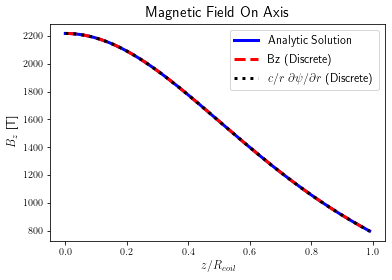

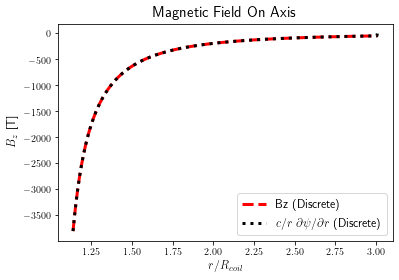

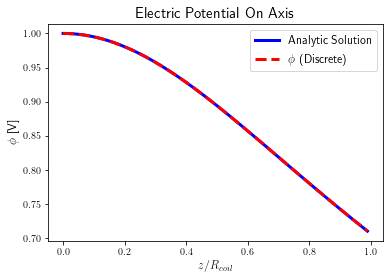

In [8]:
Field_in = 0
if Field_in == 0:
    rz = np.meshgrid(z, r)
    psi, Bz, Br, phi_coil =  dt.AGM_Dipole(20, r, z, rz, dz, C, res_r, res_z, R_coil)
    Bz[0, :] = Bz[1, :]
    #np.savetxt('psi.txt', psi)
    #np.savetxt('Bz.txt', Bz)
    #np.savetxt('Br.txt', Br)
    #np.savetxt('phi_coil.txt', phi_coil)
elif Field_in == 1:
    psi = np.loadtxt('psi.txt')
    Bz = np.loadtxt('Bz.txt')
    Br = np.loadtxt('Br.txt')
    phi_coil = np.loadtxt('phi_coil.txt')

#psi_in, Bz_in, Br_in, dpsi_dr_in = AGM_test(4, r, z, rz, dz, C, R_coil, res_r, res_z)
dpsi_dr_dis = np.zeros((res_r, res_z))
for i in range(1, res_r-1):
    dr_i = (dr[i-1]+dr[i])*r[i]
    for j in range(res_z):
        dpsi_dr_dis[i, j] = (psi[i+1, j] - psi[i-1, j])/(dr_i)

Bz_ana = C*np.pi*R_coil**2/(z**2+R_coil**2)**(3/2)

plt.plot(z/R_coil, Bz_ana, 'b', label='Analytic Solution', linewidth=3)
plt.plot(z/R_coil, Bz[0, :], 'r', label='Bz (Discrete)', linewidth=3, linestyle='dashed')
plt.plot(z/R_coil, dpsi_dr_dis[2, :], 'k', label='$c/r \ \partial \psi/\partial r$ (Discrete)', linestyle='dotted', linewidth=3)
plt.legend(fontsize = 12)
plt.xlabel('$z/R_{coil}$', fontsize=12)
plt.ylabel('$B_z$ [T]', fontsize=12)
plt.title('Magnetic Field On Axis', fontsize=15)
#plt.savefig('Bz_check.png', dpi = 400)
plt.show()

plt.plot(r[i_oe:]/R_coil, Bz[i_oe:, 0], 'r', label='Bz (Discrete)', linewidth=3, linestyle='dashed')
plt.plot(r[i_oe:]/R_coil, dpsi_dr_dis[i_oe:, 0], 'k', label='$c/r \ \partial \psi/\partial r$ (Discrete)', linestyle='dotted', linewidth=3)
plt.legend(fontsize = 12)
plt.xlabel('$r/R_{coil}$', fontsize=12)
plt.ylabel('$B_z$ [T]', fontsize=12)
plt.title('Magnetic Field On Axis', fontsize=15)
#plt.savefig('Bz_check.png', dpi = 400)
plt.show()

phi_ana = 1/np.sqrt(z**2+R_coil**2)

plt.plot(z/R_coil, phi_ana/np.max(phi_ana), 'b', label='Analytic Solution', linewidth=3)
plt.plot(z/R_coil, phi_coil[0, :]/np.max(phi_coil[0, :]), 'r', label='$\phi$ (Discrete)', linewidth=3, linestyle='dashed')
plt.legend(fontsize = 12)
plt.xlabel('$z/R_{coil}$', fontsize=12)
plt.ylabel('$\phi$ [V]', fontsize=12)
plt.title('Electric Potential On Axis', fontsize=15)
#plt.savefig('Bz_check.png', dpi = 400)
plt.show()

In [9]:
@njit(parallel=True)
def Rotation(phi, psi, mask, n, T, q, c, me, omega, dr, dz, r, res_r, res_z):
    omega_EXB = np.zeros((res_r, res_z))
    omega_Dia = np.zeros((res_r, res_z))
    omega_cent = np.zeros((res_r, res_z))

    for i in prange(1, res_r-1):
        dr_i = dr[i]+dr[i-1]
        for j in range(1, res_z-1):
            if mask[i, j] == 1:
                dz_j = dz[j]+dz[j-1]
                EzBr = ((psi[i, j+1] - psi[i, j-1])*(phi[i, j+1] - phi[i, j-1]))/dz_j**2
                ErBz = ((psi[i+1, j] - psi[i-1, j])*(phi[i+1, j] - phi[i-1, j]))/dr_i**2
                grad_nzBr = ((psi[i, j+1] - psi[i, j-1])*(n[i, j+1] - n[i, j-1]))/dz_j**2
                grad_nrBz = ((psi[i+1, j] - psi[i-1, j])*(n[i+1, j] - n[i-1, j]))/dr_i**2
                B_square = ((psi[i, j+1] - psi[i, j-1])/dz_j)**2 + ((psi[i+1, j] - psi[i-1, j])/dr_i)**2

                omega_EXB[i, j] = -c*(ErBz + EzBr)/(B_square)
                omega_Dia[i, j] = T*c*(grad_nzBr + grad_nrBz)/(q*n[i, j]*B_square)
                omega_cent[i, j] = c*me*omega**2*(psi[i-1, j] - psi[i+1, j])*r[i]/(q*B_square*dr_i)
            
    omega_cent[0, :] = 0
    
    return omega_EXB, omega_Dia, omega_cent

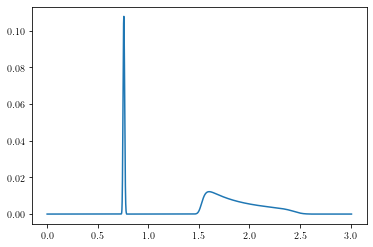

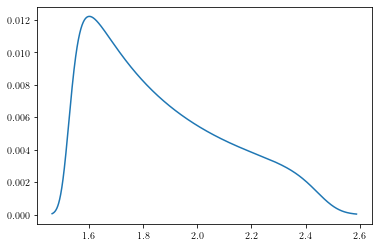

1.4697573150085508 2.5589377500812893


In [10]:
plt.plot(r/R_coil, f_lte[:, 0])
plt.show()

f_cutoff = 1e-3*np.max(f_lte)
f_norm = abs(f_lte[:, 0])
check = 0
for i in range(i_oe+1, res_r):
    if check == 0 and f_norm[i] > f_cutoff:
        i_max = i
        check = 1
    if check == 1 and f_norm[i] <= f_cutoff:     
        i_min = i
        break

mask_lte = np.zeros((res_r, res_z))
mask_lte[psi>psi[i_min, 0]] = 1
mask_lte[psi>psi[i_max, 0]] = 0
mask_lte[i_ie:i_oe, i_le:i_ue] = 0

plt.plot(r[i_max-10:i_min+10]/R_coil, f_lte[i_max-10:i_min+10, 0])
plt.show()

print(r[i_max]/R_coil, r[i_min]/R_coil)

In [11]:
dpsi = np.max(abs(psi))/10000
r_psi = [r[i_min]]
psi_r = []
n = 0
dr0 = 0.001
while r_psi[n]>=r[i_max-1]: 
    psi_n, dpsi_dr, dpsi_dz = dt.AGM_0D(20, r_psi[n], 0, R_coil, C)
    #if abs(dpsi/dpsi_dr) > abs(3*dr0):
    #    r_psi.append(r_psi[n]-abs(3*dr0))
    #else:
    r_psi.append(r_psi[n]-abs(dpsi/dpsi_dr))
    dr0 = dpsi/dpsi_dr
    psi_r.append(psi_n)
    n+=1
    if n>5000:
        print('More then 5000 grid points. Did not finish!')
        break 
print(len(r_psi))

psi_n, dpsi_dr, dpsi_dz = dt.AGM_0D(20, r[i_max], 0, R_coil, C)
psi_r.append(psi_n)
r_psi = np.array(r_psi[::-1])
psi_r = np.array(psi_r[::-1])

806


In [12]:
psi_grid_r = [[i] for i in r_psi]
psi_grid_z = [[0] for i in r_psi]
B_square = []
dS = []
B_z = []
psi_ab = []

for i in range(len(r_psi)):
    psi_n, dpsi_dr, dpsi_dz = dt.AGM_0D(20, r_psi[i], 0, R_coil, C)
    norm = (dpsi_dr**2 + dpsi_dz**2)
    B_square.append([norm/r_psi[i]**2])
    B_z.append([dpsi_dr/r_psi[i]])
    psi_ab.append([psi_n])
    
mask_grid = np.ones(len(r_psi))
ds0 = 1e-2
n = 0
z_check = 0
i_mid_ab = 0#int(len(r_psi))-1
while z_check == 0: 
    psi_n, dpsi_dr, dpsi_dz = dt.AGM_0D(20, psi_grid_r[i_mid_ab][n], psi_grid_z[i_mid_ab][n], R_coil, C)
    B_norm = np.nan_to_num(dpsi_dr**2 + dpsi_dz**2)/psi_grid_r[i_mid_ab][n]**2
    ds = ds0*np.sqrt(B_norm) #multiply stepsize by innermost magnetic field to make the grid spacing 
    dS.append(ds)            #more or less independent of B (ds = dbeta/B)  
                             #I don't make it exactly equidistance because I want the gridpoints to lie on
                             #contours of beta
    for i in range(len(r_psi)):
        if mask_grid[i] == 0:
            continue
        try:
            psi_n, dpsi_dr, dpsi_dz = dt.AGM_0D(20, psi_grid_r[i][n], psi_grid_z[i][n], R_coil, C)
        except:
            print(psi_grid_r[i][n], psi_grid_z[i][n])
            if n>0 and i>0:
                r_mean = (psi_grid_r[i][n-1]+psi_grid_r[i-1][n])/2
                z_mean = (psi_grid_z[i][n-1]+psi_grid_z[i-1][n])/2
                psi_n, dpsi_dr, dpsi_dz = dt.AGM_0D(20, r_mean, z_mean, R_coil, C)
        norm = np.nan_to_num(dpsi_dr**2 + dpsi_dz**2)
        B_square[i].append(norm/psi_grid_r[i][n]**2)
        ds_r = np.nan_to_num(psi_grid_r[i][n]*ds*dpsi_dz/norm)
        ds_z = -np.nan_to_num(psi_grid_r[i][n]*ds*dpsi_dr/norm)
        #norm = np.sqrt(np.nan_to_num(dpsi_dr**2 + dpsi_dz**2))
        #ds_r = np.nan_to_num(ds*dpsi_dz/norm)
        #ds_z = -np.nan_to_num(ds*dpsi_dr/norm)
        B_z[i].append((dpsi_dr)/psi_grid_r[i][n])
        psi_ab[i].append(psi_n)
        psi_grid_r[i].append(psi_grid_r[i][n]+ds_r) 
        psi_grid_z[i].append(psi_grid_z[i][n]+ds_z)
        if psi_grid_z[i][n+1] < 0:
            #mask_grid[i] = 0
            z_check = 1
    n+=1
    if n>5000:
        print('Did not finish!')
        break
for i in range(len(r_psi)):
    psi_grid_r[i] = np.array(psi_grid_r[i])
    psi_grid_z[i] = np.array(psi_grid_z[i])
    B_square[i] = np.array(B_square[i])
    B_z[i] = np.array(B_z[i])
    psi_ab[i] = np.array(psi_ab[i])
psi_grid_z = np.array(psi_grid_z)
psi_grid_r = np.array(psi_grid_r)
B_square = np.array(B_square)
dS = np.array(dS)
B_z = np.array(B_z)
psi_ab = np.array(psi_ab)
print(len(psi_grid_r), len(psi_grid_r[0]))

806 801


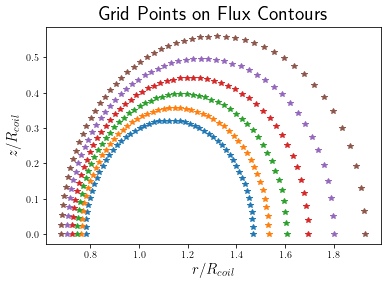

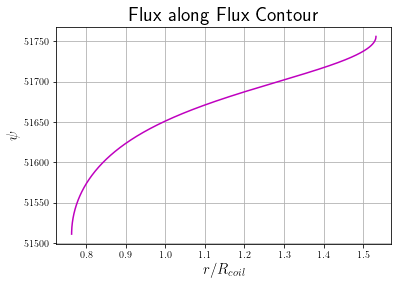

In [13]:
n_show = int(len(psi_grid_r[-1])/50)
plt.plot(psi_grid_r[0][::n_show]/R_coil, psi_grid_z[0][::n_show]/R_coil, '*')
plt.plot(psi_grid_r[100][::n_show]/R_coil, psi_grid_z[100][::n_show]/R_coil, '*')
plt.plot(psi_grid_r[200][::n_show]/R_coil, psi_grid_z[200][::n_show]/R_coil, '*')
plt.plot(psi_grid_r[300][::n_show]/R_coil, psi_grid_z[300][::n_show]/R_coil, '*')
plt.plot(psi_grid_r[400][::n_show]/R_coil, psi_grid_z[400][::n_show]/R_coil, '*')
plt.plot(psi_grid_r[500][::n_show]/R_coil, psi_grid_z[500][::n_show]/R_coil, '*')
#plt.plot(psi_grid_r[600][::n_show]/R_coil, psi_grid_z[600][::n_show]/R_coil, '*')
plt.xlabel('$r/R_{coil}$', fontsize=15)
plt.ylabel('$z/R_{coil}$', fontsize=15)
plt.title('Grid Points on Flux Contours', fontsize=20)
plt.show()

n_psi = 100
psi_check = np.empty(len(psi_grid_r[n_psi]))
for i in range(len(psi_grid_r[n_psi])):
    psi_n, dpsi_dr, dpsi_dz = dt.AGM_0D(20, psi_grid_r[n_psi][i], psi_grid_z[n_psi][i], R_coil, C)
    psi_check[i] = psi_n
psi_check = np.array(psi_check)
plt.plot(psi_grid_r[n_psi][:]/R_coil, psi_check, 'm')
plt.ylabel('$\psi$', fontsize=15)
plt.xlabel('$r/R_{coil}$', fontsize=15)
plt.title('Flux along Flux Contour', fontsize=20)
plt.grid()
plt.show()

In [14]:
@njit(parallel=True)
def inter_psi_to_rz(psi, psi_grid_r, psi_grid_z, r, z, f_ab, psi_r, mask, res_r, res_z):
    f_2d = np.zeros((res_r, res_z))
    n_max = len(psi_grid_r)
    m_max = len(psi_grid_r[0])
    for i in prange(res_r):
        for j in range(res_z):
            #if mask[i, j] == 1:
            n = np.argmin((psi_r-psi[i, j])**2)
            m = np.argmin((psi_grid_r[n][:]-r[i])**2 + (psi_grid_z[n][:]-z[j])**2)
            if mask[n, m] > 0:
                #f_2d[i, j] = f_psi_beta[n0][m0]
                ds0 = (psi_grid_r[n][m]-r[i])**2 + (psi_grid_z[n][m]-z[j])**2
                ds1 = (psi_grid_r[n+1][m]-r[i])**2 + (psi_grid_z[n+1][m]-z[j])**2
                ds2 = (psi_grid_r[n-1][m]-r[i])**2 + (psi_grid_z[n-1][m]-z[j])**2
                ds3 = (psi_grid_r[n][m+1]-r[i])**2 + (psi_grid_z[n][m+1]-z[j])**2
                ds4 = (psi_grid_r[n][m-1]-r[i])**2 + (psi_grid_z[n][m-1]-z[j])**2
                if ds1 <= ds2:
                    dx = ((psi_grid_r[n][m]-psi_grid_r[n+1][m])**2 + (psi_grid_z[n][m]-psi_grid_z[n+1][m])**2)
                    df_dx = (f_ab[n+1][m]-f_ab[n][m])/dx
                elif ds2 < ds1:
                    dx = ((psi_grid_r[n][m]-psi_grid_r[n-1][m])**2 + (psi_grid_z[n][m]-psi_grid_z[n-1][m])**2)
                    df_dx = (f_ab[n-1][m]-f_ab[n][m])/dx
                if ds3 <= ds4:
                    dy = ((psi_grid_r[n][m]-psi_grid_r[n][m+1])**2 + (psi_grid_z[n][m]-psi_grid_z[n][m+1])**2)
                    df_dy = (f_ab[n][m+1]-f_ab[n][m])/dy
                elif ds4 < ds3:
                    dy = ((psi_grid_r[n][m]-psi_grid_r[n][m-1])**2 + (psi_grid_z[n][m]-psi_grid_z[n][m-1])**2)
                    df_dy = (f_ab[n][m-1]-f_ab[n][m])/dy
                f_2d[i, j] = f_ab[n][m] + dx*df_dx + dy*df_dy
    return f_2d

In [15]:
@njit(parallel=True)
def cold_lte(r_ab, phi_mean, B_square, psi_ab, mask,dpsi):
    n_cold = np.zeros((len(r_ab), len(r_ab[0])))
    for i in prange(1, len(r_ab)-1):
        dphi_dpsi1 = (phi_mean[i+1]-phi_mean[i])/(dpsi)
        dphi_dpsi2 = (phi_mean[i]-phi_mean[i-1])/(dpsi)
        for j in range(len(r_ab[i])):
            #if mask[i, j] == 1:
            r1 = (r_ab[i+1, j]**2+r_ab[i, j]**2)/2
            r2 = (r_ab[i-1, j]**2+r_ab[i, j]**2)/2
            n_cold[i, j] = -B_square[i, j]*(r2*dphi_dpsi2-r1*dphi_dpsi1)/(dpsi)
    return n_cold

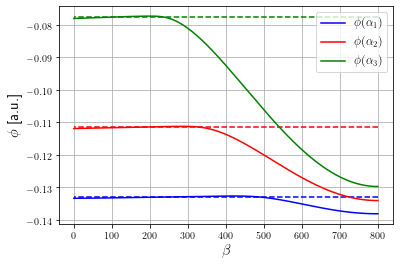

In [16]:
#b_i = 0.0
#boundary_top = phi_coil[:, -1] 
#boundary_out = phi_coil[-1, :]
#f_wall = np.zeros((res_r, res_z))
#f_wall[-1, :] = -boundary_out*(1/r[-1]+2/dr[-1])/(dr[-2] + dr[-1])
#f_wall[:, -1] += -2*boundary_top/((dz[-1] + dz[-2])*dz[-1])
#f_wall += 4*np.pi*e*n_2d
#phi_wall = lu.solve(f_wall.flatten())
#phi_wall = dt.array22d(phi_wall, res_r, res_z)
#phi_vac = -(omega/c)*R_coil*C*b_i*(phi_coil - phi_wall)
phi = lu.solve(f_lte.flatten())
phi_2d = dt.array22d(phi, res_r, res_z)
phi_interp = RectBivariateSpline(r, z, phi_2d, kx=3, ky=3)
phi_ab = phi_interp.ev(psi_grid_r, psi_grid_z)

f_interp = RectBivariateSpline(r, z, f_lte, kx=3, ky=3)
f_lte_ab = f_interp.ev(psi_grid_r, psi_grid_z)
mask_ab = np.zeros((len(psi_grid_r), len(psi_grid_r[0])))
mask_ab[f_lte_ab>f_cutoff] = 1
phi_mean = np.array([np.mean(phi_ab[n][mask_ab[n] == 1]) for n in range(len(psi_grid_r))])
deg = 10
phi_poly = np.polyfit(r_psi[1:-1], phi_mean[1:-1], deg)  
phi_fit = np.zeros(len(phi_mean))
for n in range(deg+1):
    phi_fit += phi_poly[n]*r_psi**(deg-n)

len_psi = len(phi_ab)    
plt.plot(phi_ab[int(2*len_psi/5), :], 'b', label = r'$\phi(\alpha_1)$')
plt.hlines(phi_mean[int(2*len_psi/5)], len(phi_ab[0]), 0, color = 'b', linestyle = 'dashed')
plt.plot(phi_ab[int(3*len_psi/5), :], 'r', label = r'$\phi(\alpha_2)$')
plt.hlines(phi_mean[int(3*len_psi/5)], len(phi_ab[0]), 0, color = 'r', linestyle = 'dashed')
plt.plot(phi_ab[int(4*len_psi/5), :], 'g', label = r'$\phi(\alpha_3)$')
plt.hlines(phi_mean[int(4*len_psi/5)], len(phi_ab[0]), 0, color = 'g', linestyle = 'dashed')
plt.ylabel(r'$\phi$ [a.u.]', fontsize=15)
plt.xlabel(r'$\beta$', fontsize=15)
plt.legend(fontsize = 12)
plt.grid()
plt.show()

In [17]:
@njit(parallel = True)
def Mask_ab(psi_grid_r, phi_ab, phi_fit, delta_phi):
    mask_ab = np.zeros((len(psi_grid_r), len(psi_grid_r[0])))
    for n in prange(len(psi_grid_r)):
        for m in range(len(psi_grid_r[0])):
            #if phi_ab[n, m]-phi_fit[n] <= abs(phi_fit[n])*delta_phi and phi_ab[n, m]-phi_fit[n] > -abs(phi_fit[n])*delta_phi/10:
            if phi_ab[n, m]-phi_fit[n] <= abs(phi_fit[n])*delta_phi and phi_ab[n, m]-phi_fit[n] > 0:
                mask_ab[n, m] = 1 
    return mask_ab

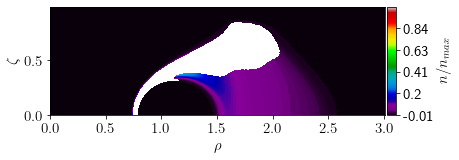

In [18]:
phi = lu.solve(f_lte.flatten())
phi_2d = dt.array22d(phi, res_r, res_z)
phi_interp = RectBivariateSpline(r, z, phi_2d, kx=3, ky=3)
phi_ab = phi_interp.ev(psi_grid_r, psi_grid_z)
#psi_contour = np.zeros((res_r, res_z))
#len_psi = len(psi_ab)
#psi_contour[psi<psi_ab[int(2*len_psi/5), 0]] = 0.2
#psi_contour[psi<psi_ab[int(3*len_psi/5), 0]] = 0.4
#psi_contour[psi<psi_ab[int(4*len_psi/5), 0]] = 0.6
delta_phi = 3e-2
mask_ab = Mask_ab(psi_grid_r, phi_ab, phi_fit, delta_phi)
mask_2d = mask_lte*inter_psi_to_rz(psi, psi_grid_r, psi_grid_z, r, z, mask_ab, psi_r, mask_ab, res_r, res_z)

maxi = 1.05
mini = -0.01
contours_C = np.arange(mini, maxi, (maxi-mini)/200)
contours_mask = np.arange(0, 1.1, 0.1)

fig, ax = plt.subplots(figsize=(6, 2))
im = ax.contourf(r/R_coil, z/R_coil, np.transpose(f_lte/np.max(f_lte)), contours_C, cmap='nipy_spectral')
#im_mask = ax.contourf(r/R_coil, z/R_coil, np.transpose(mask_2d), contours_mask, colors='none', hatches='\\\\')
im_mask = ax.contourf(r/R_coil, z/R_coil, np.transpose(mask_2d), contours_mask, colors='w')
ax.set_xlabel(r"$\rho$", fontsize = 15)
ax.set_ylabel(r"$\zeta$", fontsize = 15)
ax.tick_params(labelsize=15) 
cb_ax = fig.add_axes([0.905, 0.125, 0.02, 0.755])
cbar = fig.colorbar(im, cax=cb_ax, ticks = np.arange(mini, maxi+(maxi-mini)/5, (maxi-mini)/5))
tick_labels = [str(round(i, 2)) for i in np.arange(mini, maxi+(maxi-mini)/5, (maxi-mini)/5)]
cbar.ax.set_yticklabels(tick_labels, fontsize=15)
cbar.set_label(label = r'$n/n_{max}$',fontsize=15)
#ax.set_title('$\phi + Tln(n/n_0)/q$', fontsize=20)
#plt.savefig('Force_Balance_LTE.png', dpi = 400)
plt.show()

#f_interp = RectBivariateSpline(r, z, f_lte, kx=3, ky=3)
#f_check_ab = f_interp.ev(psi_grid_r, psi_grid_z)
#f_check = inter_psi_to_rz(psi, psi_grid_r, psi_grid_z, r, z, f_check_ab, psi_r, mask_lte, res_r, res_z)

#fig, ax = plt.subplots(figsize=(6, 2))
#im = ax.contourf(r/R_coil, z/R_coil, np.transpose(f_check/np.max(f_check)), contours_C, cmap='nipy_spectral')
#im_mask = ax.contour(r/R_coil, z/R_coil, np.transpose(mask_2d), contours_mask, colors='w')
#im_psi = ax.contour(r/R_coil, z/R_coil, np.transpose(psi_contour), contours_C, colors='w', linestyles='dashed')
#ax.set_xlabel(r"$\rho$", fontsize = 15)
#ax.set_ylabel(r"$\xi$", fontsize = 15)
#ax.tick_params(labelsize=15) 
#cb_ax = fig.add_axes([0.905, 0.125, 0.02, 0.755])
#cbar = fig.colorbar(im, cax=cb_ax, ticks = np.arange(mini, maxi+(maxi-mini)/5, (maxi-mini)/5))
#tick_labels = [str(round(i, 2)) for i in np.arange(mini, maxi+(maxi-mini)/5, (maxi-mini)/5)]
#cbar.ax.set_yticklabels(tick_labels, fontsize=15)
#cbar.set_label(label = r'$n/n_{max}$',fontsize=15)
#ax.set_title('$\phi + Tln(n/n_0)/q$', fontsize=20)
#plt.savefig('Force_Balance_LTE.png', dpi = 400)
#plt.show()

In [19]:
@njit(parallel=True)
def N_error(d2phi, f, mask, r, z, dz, e, res_r, res_z):
    error = d2phi+f     
    E = 0
    for i in prange(1, res_r-1):
        for j in range(res_z-1):
            E = E + mask[i, j]*np.pi*error[i*res_z+j]*(r[i+1]**2-r[i-1]**2+2*r[i]*(r[i+1]-r[i-1]))*dz[j]/2
    return(E/(4*np.pi*e))

In [20]:
dchi = np.array([np.sqrt(B_square[n_psi, n]*((psi_grid_r[n_psi, n+1]-psi_grid_r[n_psi, n])**2+(psi_grid_z[n_psi, n+1]-psi_grid_z[n_psi, n])**2)) for n in range(len(psi_grid_r[n_psi])-1)])
chi = np.zeros(len(dchi))
for i in range(1, len(chi)):
    chi[i] = chi[i-1]+dchi[i]
chi = chi/(R_coil*Bz[0, 0])

In [21]:
mask_ab = np.ones((len(psi_grid_r), len(psi_grid_r[0])))
f_cold = cold_lte(psi_grid_r, phi_fit, B_square, psi_ab, mask_ab, dpsi)

N = 1.07e+10
Iteration  1000
Error = 2.02e+06
sum(Mask) = 3.53e+05
delta_phi = 1.12e-02

Iteration  2000
Error = 1.66e+07
sum(Mask) = 3.53e+05
delta_phi = 4.22e-03

Iteration  3000
Error = 7.94e+06
sum(Mask) = 3.54e+05
delta_phi = 2.94e-03

Iteration  4000
Error = 9.04e+07
sum(Mask) = 3.49e+05
delta_phi = 2.37e-03

Iteration  5000
Error = 3.54e+07
sum(Mask) = 3.52e+05
delta_phi = 2.16e-03

Iteration  6000
Error = 2.09e+07
sum(Mask) = 3.54e+05
delta_phi = 2.07e-03

Iteration  7000
Error = 1.97e+07
sum(Mask) = 3.54e+05
delta_phi = 2.04e-03

Iteration  8000
Error = 5.66e+06
sum(Mask) = 3.54e+05
delta_phi = 2.02e-03



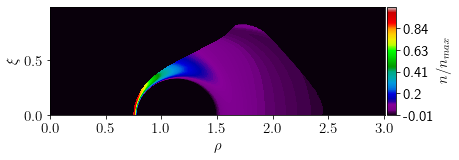

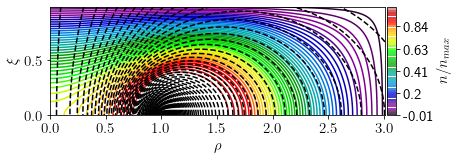

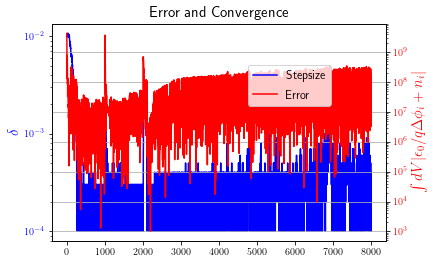

In [22]:
itr = 8001
guess = 0
delta = 0.01   #Step width for the change of the potentiall from one iteration to the next
ddelta = 0.01*delta #Change of step width if error decreases
delta_min = 0.01*delta #Minimum Step width
delta_phi = 3e-2
filename_save = 'LTE_Cold'

for b_i in [0.0]:#, 0.7*1e7*e, 0.6*1e7*e]:

    #b_i = 0.0
    #boundary_top = phi_coil[:, -1] 
    #boundary_out = phi_coil[-1, :]
    #f_wall = np.zeros((res_r, res_z))
    #f_wall[-1, :] = -boundary_out*(1/r[-1]+2/dr[-1])/(dr[-2] + dr[-1])
    #f_wall[:, -1] += -2*boundary_top/((dz[-1] + dz[-2])*dz[-1])
    #f_wall += 4*np.pi*e*n_2d
    #phi_wall = lu.solve(f_wall.flatten())
    #phi_wall = dt.array22d(phi_wall, res_r, res_z)
    #phi_vac = -(omega/c)*R_coil*C*b_i*(phi_coil - phi_wall)
    phi_vac = np.zeros((res_r, res_z))
    
    if guess == 0:       
        f_2d = f_lte.copy()
        f_2d[f_2d<0] = 0
        F0 = dt.N_tot(f_2d, r, z, dr, dz, res_r, res_z)
        N0 = F0/(4*np.pi*e)
        print('N = %1.2e' %(N0))
        f = f_2d.flatten()
        phi = lu.solve(f_lte.flatten())
        phi_2d = dt.array22d(phi, res_r, res_z)
        phi_interp = RectBivariateSpline(r, z, phi_2d, kx=3, ky=3)
        phi_ab = phi_interp.ev(psi_grid_r, psi_grid_z)
        #mask_ab = Mask_ab(psi_grid_r, phi_ab, phi_fit, delta_phi)
        #mask_ab = np.zeros((len(psi_grid_r), len(psi_grid_r[0])))
        #mask_ab[f_lte_ab>f_cutoff] = 1
        #f_ab = cold_lte(psi_grid_r, phi_fit, B_square, psi_ab, mask_ab, dpsi)
        #f_ab = mask_ab*f_ab
        #f_ab[f_ab<0] = 0 
        #f_2d = mask_lte*inter_psi_to_rz(psi, psi_grid_r, psi_grid_z, r, z, f_ab, psi_r, mask_ab, res_r, res_z)

        diff = 1e20 #Initialize difference between iteration, I use that as a measure of the convergence
        sum_error = 1e30
    else:#elif guess == 1:
        #filename_save = 'LTE_T0.0'
        filename_save = 'LTE_Cold'
        phi_2d = np.loadtxt(filename_save+'potential.txt')
        f_2d = np.loadtxt(filename_save+'distribution.txt')
        #phi_2d = np.loadtxt(filename_load+'_T'+str(round(T/T0, 2))+'potential.txt')
        f = f_2d.flatten()
        phi = phi_2d.flatten()
        phi_tot = phi_2d + phi_vac
        phi_interp = RectBivariateSpline(r, z, phi_tot, kx=1, ky=1)
        phi_ab = phi_interp.ev(psi_grid_r, psi_grid_z)
        phi_ab = np.nan_to_num(phi_ab)
        mask_ab = Mask_ab(psi_grid_r, phi_ab, phi_fit, delta_phi)
        #mask_ab = np.zeros((len(psi_grid_r), len(psi_grid_r[0])))
        #mask_ab[f_lte_ab>f_cutoff] = 1
        #F0 = dt.N_tot(f_2d, r, z, dr, dz, res_r, res_z)
        #N0 = F0/(4*np.pi*e)
        #N0 = 5.3e9
        #F0 = N0*(4*np.pi*e)
        #print('N = %1.2e' %(N0))
        #Diff = list(np.loadtxt(filename+'Divergence.txt'))
        #Error = list(np.loadtxt(filename+'Error.txt'))
        sum_error = 1e30#Error[-1]
        diff = 1e20#Diff[-1]

    sum_mask = 0
    Error = np.zeros((itr))
    Diff = np.zeros((itr)) 
    Delta = np.zeros((itr))
    Sum_Mask = np.zeros((itr))

    #f_cold = cold_lte(psi_grid_r, phi_fit, B_square, psi_ab, q, dpsi)
    #f_cold[f_cold<0] = 0
    for m in range(itr):
        
        f0 = f  #Save last distribution and calculate new Boltzmann distribuion from old potential
        mask_ab = Mask_ab(psi_grid_r, phi_ab, phi_fit, delta_phi)
        f_2d = mask_lte*inter_psi_to_rz(psi, psi_grid_r, psi_grid_z, r, z, f_cold, psi_r, mask_ab, res_r, res_z)
        f_2d[f_2d<0] = 0
        f = f_2d.flatten()

        d2phi = A.dot(-phi)
        sum_error0 = sum_error
        sum_error = abs(N_error(d2phi, f, mask_lte, r, z, dz, e, res_r, res_z))
        Error[m] = np.nan_to_num(sum_error) #Add error to list
        sum_mask0 = sum_mask
        sum_mask = np.sum(mask_ab)
        Sum_Mask[m] = sum_mask

        diff0 = diff #Save old difference
        diff = np.sum(abs(f-f0)) #Calculate new difference
        Diff[m] = np.nan_to_num(np.sum(diff)) #Add difference to list 
        Delta[m] = np.nan_to_num(np.sum(delta)) #Add difference to list 
        if sum_error <= sum_error0:
            #phi1 = lu.solve(delta*f + (1-delta)*f0)
            phi1 = lu.solve(f)
            phi = phi1*delta + (1-delta)*phi #Solve Poissons Equation
            delta += ddelta
            if sum_mask >= sum_mask0:
                delta_phi = 2e-3 + (delta_phi-2e-3)*0.997
        else:
            phi1 = lu.solve(f0)
            phi = phi1*delta + (1-delta)*phi
            delta = np.max((delta-2*ddelta, delta_min))
            #delta = np.max((delta-ddelta, delta_min))
        phi = np.nan_to_num(phi)
        phi_2d = dt.array22d(phi, res_r, res_z)
        phi_tot = phi_2d + phi_vac
        phi_interp = RectBivariateSpline(r, z, phi_tot, kx=1, ky=1)
        phi_ab = phi_interp.ev(psi_grid_r, psi_grid_z)
        phi_ab = np.nan_to_num(phi_ab)

        if m%1000 == 0 and m>0:
            #mask_ab = Mask_ab(psi_grid_r, phi_ab, phi_fit, delta_phi)
            print('Iteration ', m)
            print('Error = %1.2e' %(sum_error))
            print('sum(Mask) = %1.2e' %(np.sum(mask_ab)))
            print('delta_phi = %1.2e' %(delta_phi))
            print('')
            if delta_phi > 3.5e-3:
                F_warm = dt.N_tot(f_lte, r, z, dr, dz, res_r, res_z)
                F_cold = dt.N_tot(f_2d, r, z, dr, dz, res_r, res_z)
                phi_fit = (F_warm/F_cold)*phi_fit
                phi_ab = (F_warm/F_cold)*phi_ab
                f = (F_warm/F_cold)*f
                mask_ab = np.ones((len(psi_grid_r), len(psi_grid_r[0])))
                f_cold = cold_lte(psi_grid_r, phi_fit, B_square, psi_ab, mask_ab, dpsi)
            if np.sum(mask_ab) > 0:
                np.savetxt(filename_save+'potential.txt', phi_2d)
                np.savetxt(filename_save+'distribution.txt', f_2d)
            #delta_phi -= 1e-3
        
    n_2d = f_2d/(4*np.pi*e)
    n_2d[i_ie:i_oe, i_le:i_ue] = 0
    mask_ab = Mask_ab(psi_grid_r, phi_ab, phi_fit, delta_phi)
    mask_2d = inter_psi_to_rz(psi, psi_grid_r, psi_grid_z, r, z, mask_ab, psi_r, mask_ab, res_r, res_z)

    i_max_n = np.argmax(n_2d[:i_ie, 0])
    maxi = 1.05
    mini = -0.01
    psi_contour = np.zeros((res_r, res_z))
    psi_contour[psi < psi[i_max_n, 0]] = 0.01
    contours_C = np.arange(mini, maxi, (maxi-mini)/200)
    contours_mask = np.arange(0, 1.1, 0.1)

    fig, ax = plt.subplots(figsize=(6, 2))
    im = ax.contourf(r/R_coil, z/R_coil, np.transpose(n_2d/np.max(n_2d)), contours_C, cmap='nipy_spectral')
    #im_mask = ax.contourf(r/R_coil, z/R_coil, np.transpose(mask_2d), contours_mask, colors='w')
    #im_psi = ax.contour(r/R_coil, z/R_coil, np.transpose(psi_contour), contours_C, colors='w', linestyles='dashed')
    ax.set_xlabel(r"$\rho$", fontsize = 15)
    ax.set_ylabel(r"$\xi$", fontsize = 15)
    ax.tick_params(labelsize=15) 
    cb_ax = fig.add_axes([0.905, 0.125, 0.02, 0.755])
    cbar = fig.colorbar(im, cax=cb_ax, ticks = np.arange(mini, maxi+(maxi-mini)/5, (maxi-mini)/5))
    tick_labels = [str(round(i, 2)) for i in np.arange(mini, maxi+(maxi-mini)/5, (maxi-mini)/5)]
    cbar.ax.set_yticklabels(tick_labels, fontsize=15)
    cbar.set_label(label = r'$n/n_{max}$',fontsize=15)
    #ax.set_title('$\phi + Tln(n/n_0)/q$', fontsize=20)
    #plt.savefig('Force_Balance_LTE.png', dpi = 400)
    plt.show()
    
    contours_phi = np.arange(mini, maxi, (maxi-mini)/50)
    fig, ax = plt.subplots(figsize=(6, 2))
    im = ax.contour(r/R_coil, z/R_coil, np.transpose(phi_tot/np.min(phi_tot)), contours_phi, cmap='nipy_spectral')
    im_mask = ax.contour(r/R_coil, z/R_coil, np.transpose(mask_2d), contours_mask, colors='none', hatches='\\\\')
    im_psi = ax.contour(r/R_coil, z/R_coil, np.transpose(psi/np.max(psi)), contours_C, colors='k', linestyles='dashed')
    ax.set_xlabel(r"$\rho$", fontsize = 15)
    ax.set_ylabel(r"$\xi$", fontsize = 15)
    ax.tick_params(labelsize=15) 
    cb_ax = fig.add_axes([0.905, 0.125, 0.02, 0.755])
    cbar = fig.colorbar(im, cax=cb_ax, ticks = np.arange(mini, maxi+(maxi-mini)/5, (maxi-mini)/5))
    tick_labels = [str(round(i, 2)) for i in np.arange(mini, maxi+(maxi-mini)/5, (maxi-mini)/5)]
    cbar.ax.set_yticklabels(tick_labels, fontsize=15)
    cbar.set_label(label = r'$n/n_{max}$',fontsize=15)
    #ax.set_title('$\phi + Tln(n/n_0)/q$', fontsize=20)
    #plt.savefig('Force_Balance_LTE.png', dpi = 400)
    plt.show()

    fig, ax1 = plt.subplots()
    color = 'b'
    ax1.set_ylabel('$\delta$', color=color, fontsize = 15)
    ax1.plot(Delta[:m], label='Stepsize', color = 'b')
    ax1.tick_params(axis='y', labelcolor=color)
    plt.yscale('log')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-ax
    color = 'r'
    ax2.set_ylabel('$\int dV |\epsilon_0/q \Delta\phi_i+n_i|$', color=color, fontsize = 15)
    ax2.plot(Error[:m], label='Error', color = 'r')
    ax2.tick_params(axis='y', labelcolor=color)
    plt.yscale('log')
    plt.grid()
    fig.legend(loc = (0.57, 0.6), fontsize = 12)
    plt.title('Error and Convergence', fontsize = 15)
    #plt.savefig('Error_Convergence.jpg', dpi = 400)
    plt.show()   

    filename_save = 'LTE_Cold'
    save = 'y'
    #save = input('save data? y/n ')
    if save == 'y':    
        #np.savetxt(filename_save+'_T'+str(round(T/T0, 2))+'potential.txt', phi_2d)
        #np.savetxt(filename_save+'_T'+str(round(T/T0, 2))+'distribution.txt', f_2d)
        np.savetxt(filename_save+'potential.txt', phi_2d)
        np.savetxt(filename_save+'distribution.txt', f_2d)

    #del f0, phi, phi1

In [23]:
filename_save = 'LTE'
T = [1.0, 0.5, 0.1, 0.0]
n1 = np.loadtxt(filename_save+'_'+str(round(T[0], 2))+'distribution.txt')/(4*np.pi*e)
phi1 = np.loadtxt(filename_save+'_'+str(round(T[0], 2))+'potential.txt')
n1[i_ie:i_oe, i_le:i_ue] = 0

n2 = np.loadtxt(filename_save+'_'+str(round(T[1], 2))+'distribution.txt')/(4*np.pi*e)
phi2 = np.loadtxt(filename_save+'_'+str(round(T[1], 2))+'potential.txt')
n2[i_ie:i_oe, i_le:i_ue] = 0

n3 = np.loadtxt(filename_save+'_'+str(round(T[2], 2))+'distribution.txt')/(4*np.pi*e)
phi3 = np.loadtxt(filename_save+'_'+str(round(T[2], 2))+'potential.txt')
n3[i_ie:i_oe, i_le:i_ue] = 0

#n4 = np.loadtxt(filename_save+'_T'+str(round(T[3], 2))+'distribution.txt')/(4*np.pi*e)
#phi4 = np.loadtxt(filename_save+'_T'+str(round(T[3], 2))+'potential.txt')
#n4[i_ie:i_oe, i_le:i_ue] = 0
n4 = np.loadtxt(filename_save+'_Colddistribution.txt')/(4*np.pi*e)
phi4 = np.loadtxt(filename_save+'_Coldpotential.txt')
n4[i_ie:i_oe, i_le:i_ue] = 0

In [24]:
V_well = 0
for i in range(1, res_r-1):
    for j in range(res_z-1):
        if n1[i, j] > 0:
            V_well = V_well + np.pi*(r[i+1]**2-r[i-1]**2+2*r[i]*(r[i+1]-r[i-1]))*dz[j]/2
N0 = dt.N_tot(n1, r, z, dr, dz, res_r, res_z)
n0 = N0/V_well

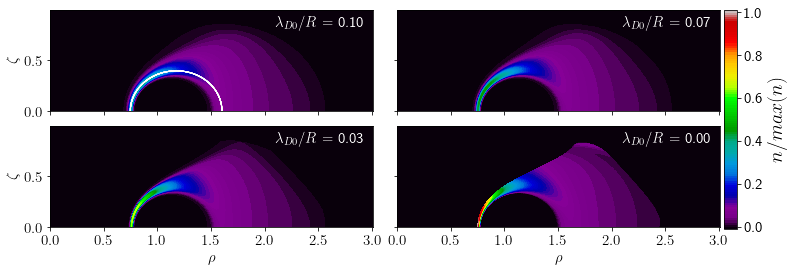

In [43]:
scale_n = 1/np.max(n4)#e**2*R_coil**2/(T0*T[0])

maxi = 1.02
mini = -0.01#np.min(n4*10**-mag_n)
contours_n = np.arange(mini, maxi, (maxi-mini)/100)
contour_psi = np.arange(0, 1.1, 0.1)

n_interp = RectBivariateSpline(r, z, n1, kx=3, ky=3)
n_ab = n_interp.ev(psi_grid_r, psi_grid_z)
len_a = len(n_ab[0])
psi_contour = np.zeros((res_r, res_z))
#psi_contour[psi<psi_r[np.argmax(n_ab)//len_a-10]] = 1
psi_contour[psi<psi[np.argmax(n2[i_oe:, 0])+i_oe, 0]] = 1

fig, axs = plt.subplots(2, 2, sharex='col', sharey='row', gridspec_kw={'wspace': 0.075, 'hspace': 0.15}, figsize=(12, 4))
((ax1, ax2), (ax3, ax4)) = axs

im1 = ax1.contourf(r/R_coil, z/R_coil, np.transpose(mask_lte*scale_n*n1), contours_n, cmap='nipy_spectral')
ax1.contour(r/R_coil, z/R_coil, np.transpose(psi_contour), contour_psi, colors='w', linewidths=1)
ax1.set_ylabel(r"$\zeta$", fontsize = 15)
ax1.tick_params(axis ='both', labelsize=15)
ax1.text(2.1, 0.8, r'$\lambda_{D0}/R$ = %1.2f' %(np.sqrt(T0*T[0]/(4*np.pi*e**2*n0))/R_coil), color = 'w', fontsize=15)

im2 = ax2.contourf(r/R_coil, z/R_coil, np.transpose(mask_lte*scale_n*n2), contours_n, cmap='nipy_spectral')
ax2.tick_params(axis ='both', labelsize=15)
ax2.text(2.1, 0.8, r'$\lambda_{D0}/R$ = %1.2f' %(np.sqrt(T0*T[1]/(4*np.pi*e**2*n0))/R_coil), color = 'w', fontsize=15)

im3 = ax3.contourf(r/R_coil, z/R_coil, np.transpose(mask_lte*scale_n*n3), contours_n, cmap='nipy_spectral')
ax3.set_xlabel(r"$\rho$", fontsize = 15)
ax3.set_ylabel(r"$\zeta$", fontsize = 15)
ax3.tick_params(axis ='both', labelsize=15)
ax3.text(2.1, 0.8, r'$\lambda_{D0}/R$ = %1.2f' %(np.sqrt(T0*T[2]/(4*np.pi*e**2*n0))/R_coil), color = 'w', fontsize=15)

im4 = ax4.contourf(r/R_coil, z/R_coil, np.transpose(mask_lte*scale_n*n4), contours_n, cmap='nipy_spectral')
ax4.set_xlabel(r"$\rho$", fontsize = 15)
ax4.tick_params(axis ='both', labelsize=15)
ax4.text(2.1, 0.8, r'$\lambda_{D0}/R$ = %1.2f' %(np.sqrt(T0*T[3]/(4*np.pi*e**2*n0))/R_coil), color = 'w', fontsize=15)

cb_ax = fig.add_axes([0.905, 0.12, 0.015, 0.76])
cbar = fig.colorbar(im4, cax=cb_ax, ticks = np.arange(0, 1.2, 0.2))
tick_labels = [str(abs(round(i, 1))) for i in np.arange(0, 1.2, 0.2)]
cbar.ax.set_yticklabels(tick_labels, fontsize=15) 
cbar.set_label(label = '$n/max(n)$',fontsize=20)
plt.savefig('Steinbrunner_Fig10.png', format = 'png', bbox_inches="tight", dpi=300)
plt.savefig('Steinbrunner_Fig10.tif', format = 'tif', bbox_inches="tight", dpi=300)

In [26]:
N4 = dt.N_tot(n4, r, z, dr, dz, res_r, res_z)
print('N = %1.2e' %(N0))

N3 = dt.N_tot(n3, r, z, dr, dz, res_r, res_z)
print('N = %1.2e' %(N0))
print(N3/N4)

N = 1.07e+10
N = 1.07e+10
0.9979858998235182


In [27]:
phi_interp = RectBivariateSpline(r, z, phi1, kx=3, ky=3)
phi1_ab = phi_interp.ev(psi_grid_r, psi_grid_z)
phi1_ab = np.nan_to_num(phi1_ab)
phi_interp = RectBivariateSpline(r, z, phi2, kx=3, ky=3)
phi2_ab = phi_interp.ev(psi_grid_r, psi_grid_z)
phi2_ab = np.nan_to_num(phi2_ab)
phi_interp = RectBivariateSpline(r, z, phi3, kx=3, ky=3)
phi3_ab = phi_interp.ev(psi_grid_r, psi_grid_z)
phi3_ab = np.nan_to_num(phi3_ab)
phi_interp = RectBivariateSpline(r, z, phi4, kx=3, ky=3)
phi4_ab = phi_interp.ev(psi_grid_r, psi_grid_z)
phi4_ab = np.nan_to_num(phi4_ab)

In [28]:
dchi = np.array([np.sqrt(B_square[n_psi, n]*((psi_grid_r[n_psi, n+1]-psi_grid_r[n_psi, n])**2+(psi_grid_z[n_psi, n+1]-psi_grid_z[n_psi, n])**2)) for n in range(len(psi_grid_r[n_psi])-1)])
chi = np.zeros(len(dchi))
for i in range(1, len(chi)):
    chi[i] = chi[i-1]+dchi[i]
chi = chi/(R_coil*Bz[0, 0])

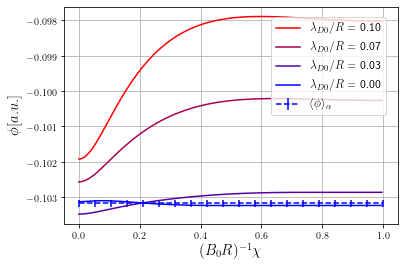

In [41]:
N4 = dt.N_tot(n4, r, z, dr, dz, res_r, res_z)
N3 = dt.N_tot(n3, r, z, dr, dz, res_r, res_z)

norm = c**2/(omega*I*R_coil)
#n_psi = np.argmax(f_ab)//len_a
n_psi = np.argmin(abs(psi_r-psi[np.argmax(n3)//res_z, np.argmax(n3)%res_z]))
#phi_input = np.array(20*[phi_mean[n_psi]])
#phi_input = np.array(20*[phi_fit[n_psi]])
phi_input = np.array(20*[np.mean(phi4_ab[n_psi][:-1])])
phi_bars = np.zeros((2, 20)) 
phi_bars[0, :] = delta_phi*phi_fit[n_psi]*norm
delta_phi = 2e-3

plt.plot(chi, norm*phi1_ab[n_psi][:-1], color = (1, 0, 0, 1), label=r'$\lambda_{D0}/R$ = %1.2f' %(np.sqrt(T0*T[0]/(4*np.pi*e**2*n0))/R_coil))
plt.plot(chi, norm*phi2_ab[n_psi][:-1], color = (0.66, 0.0, 0.33, 1), label=r'$\lambda_{D0}/R$ = %1.2f' %(np.sqrt(T0*T[1]/(4*np.pi*e**2*n0))/R_coil))
plt.plot(chi, norm*phi3_ab[n_psi][:-1], color = (0.33, 0.0, 0.66, 1), label=r'$\lambda_{D0}/R$ = %1.2f' %(np.sqrt(T0*T[2]/(4*np.pi*e**2*n0))/R_coil))
plt.plot(chi, norm*phi4_ab[n_psi][:-1], color = (0, 0, 1, 1), label=r'$\lambda_{D0}/R$ = %1.2f' %(np.sqrt(T0*T[3]/(4*np.pi*e**2*n0))/R_coil))
plt.errorbar(np.linspace(0, 1, 20), norm*phi_input, delta_phi*phi_fit[n_psi]*norm/2, color = (0, 0, 1, 1), label =r'$\langle \phi \rangle_{\alpha}$', linestyle = 'dashed')
plt.ylabel('$\phi [a.u.]$', fontsize=15)
plt.xlabel(r'$(B_0R)^{-1} \chi$', fontsize=15)
plt.grid()
plt.legend(loc = (0.62, 0.5), fontsize = 12)
plt.savefig('Steinbrunner_Fig11.png', format = 'png', bbox_inches="tight", dpi=300)
plt.savefig('Steinbrunner_Fig11.tif', format = 'tif', bbox_inches="tight", dpi=300)
plt.show()